In [1]:
import nest
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import elephant
import quantities as pq
import neo
import sys
from scipy.stats import ks_2samp
plt.rcParams['figure.figsize'] = (14, 10)
import scipy.stats as stats
import itertools
import random
# If seaborn and elephant not available, run the sommands:
# !{sys.executable} -m pip install elephant
# !{sys.executable} -m pip install seaborn

Unexpectedly, the p-values for KS-tests of pairwise simulations from the same model were not uniformply distributed. We try to look more into the underlying distributions. Lets start by looking at the CV distributions of the Brunel model with rounded spike times and delay from the discrete interval [1.0, 2.0].

In [2]:
def get_cvs(spike_data):
    """
    Get the CV for each neuron recorded. 
    
    CV = standard_deviation(ISIs)/mean(ISIs)
    """
    cvs = []
     
    spike_data = spike_data.sort_values(by='time_ms')
    grouped = spike_data.groupby(spike_data['sender'])

    for name, group in grouped:
            """
            Each group is senders and times for one value of senders. That is, we iterate through all 
            neurons. And the times for each neuron is in sorted order. Therefore, the cvs
            returned must have the same order. So cvs contain cv of neuron 1, then neuron 2 .... then neuron N.
            """
            t = np.asarray(group['time_ms'])
            spiketrain = neo.core.SpikeTrain(t * pq.ms, t_start=0*pq.ms, t_stop=10000*pq.ms)
            isi = elephant.statistics.isi(spiketrain)
            cv = elephant.statistics.cv(isi)
            cvs.append(cv)
            
    return cvs

In [3]:
def get_cv_lists(exc, inh):
    cv_list_exc = list()
    for i in range(1,11):
        exc_cvs = get_cvs(exc[i])
        cv_list_exc.append(exc_cvs)

    cv_list_inh = list()
    for i in range(1,11):
        inh_cvs = get_cvs(inh[i])
        cv_list_inh.append(inh_cvs)
    return cv_list_exc, cv_list_inh

In [8]:
def round_1_2():
    """
    Get spike data from brunel model with rounded spike times and delays drawn from discrete interval [1.0, 2.0].
    """
    spike_path = '/opt/data/spike_data/brunel_10s/brunel_rounding_1_2'
    exc = {}
    for i in range(1,11):
        exc[i] = pd.read_csv(r'{}/brunel_rounding_True_delay_1.0_2.0_seed_{}_spikes_exc-12502-0.dat'.format(spike_path, i),
                             skiprows=2,sep='\t')

    inh = {}
    for i in range(1,11):
        inh[i] = pd.read_csv(r'{}/brunel_rounding_True_delay_1.0_2.0_seed_{}_spikes_inh-12503-0.dat'.format(spike_path, i),
                             skiprows=2,sep='\t')
    return exc, inh

In [5]:
def ks_test(value_list):
    """
    Perform KS-test on all possible pairs of simulations from same model. (10 simulations). 
    Return statistic and p-values.
    """
    statistics = []
    p_values = []
    for i in range(0,10):
        for j in range(0,i):
            statistic = ks_2samp(value_list[i], value_list[j], alternative='two-sided')[0]
            p_value = ks_2samp(value_list[i], value_list[j], alternative='two-sided')[1]
            p_values.append(p_value)
            statistics.append(statistic)
    return statistics, p_values
        

In [12]:
def num_fail_pass(p_values, significance_level=0.01):
    """
    Get number of tests which failed and which passed.
    """
    failed = 0
    passed = 0
    for i in range(0,len(p_values)):
        if p_values[i] < significance_level:
            # test fails
            failed += 1
        else:
            passed += 1
    s = str(passed) + ' tests passed, ' + str(failed) + ' tests failed.'
    return s

Retrieve the data

In [9]:
exc, inh = round_1_2()

In [10]:
cv_list_exc, cv_list_inh = get_cv_lists(exc, inh)

In [16]:
statistics_exc, p_values_exc = ks_test(cv_list_exc)
statistics_inh, p_values_inh = ks_test(cv_list_inh)

In [17]:
s1 = num_fail_pass(p_values_exc)
print(s1)
s2 = num_fail_pass(p_values_inh)
print(s2)

34 tests passed, 11 tests failed.
43 tests passed, 2 tests failed.


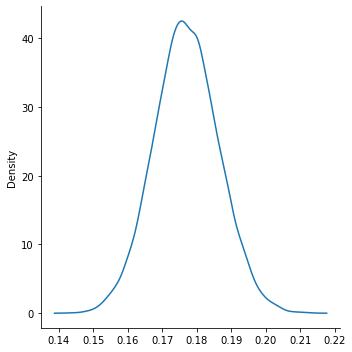

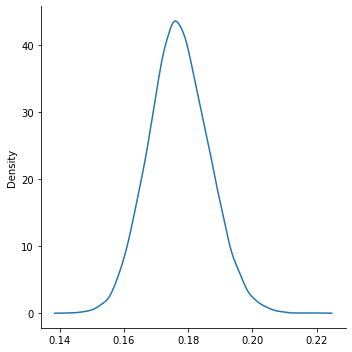

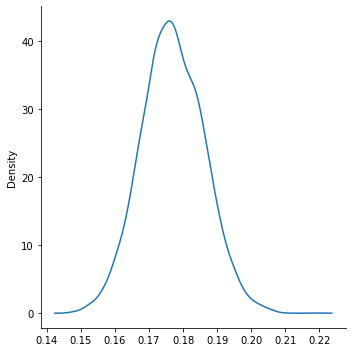

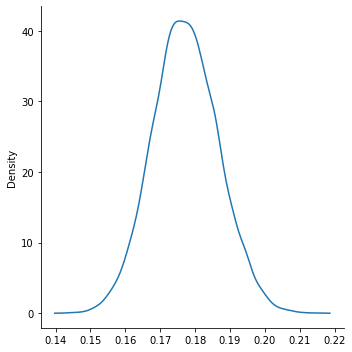

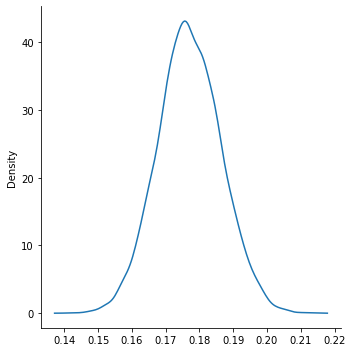

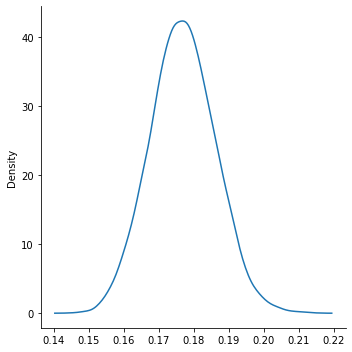

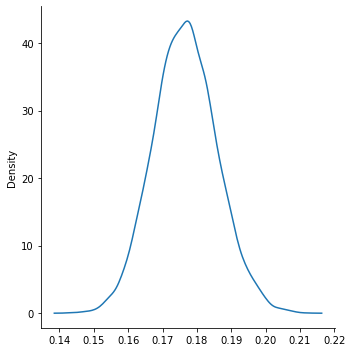

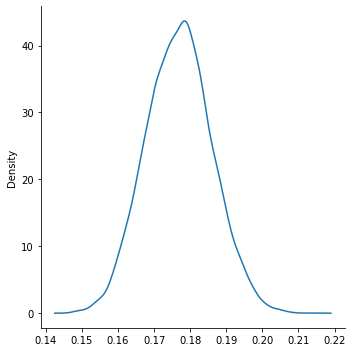

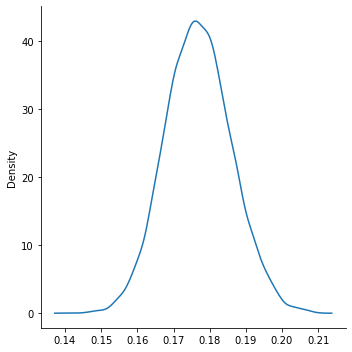

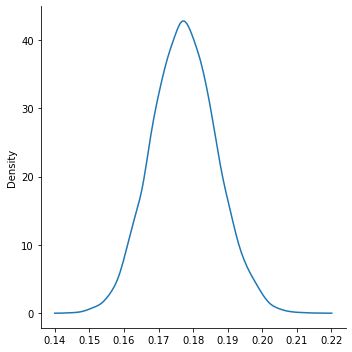

In [22]:
sns.displot(cv_list_exc[0], kind='kde')
sns.displot(cv_list_exc[1], kind='kde')
sns.displot(cv_list_exc[2], kind='kde')
sns.displot(cv_list_exc[3], kind='kde')
sns.displot(cv_list_exc[4], kind='kde')
sns.displot(cv_list_exc[5], kind='kde')
sns.displot(cv_list_exc[6], kind='kde')
sns.displot(cv_list_exc[7], kind='kde')
sns.displot(cv_list_exc[8], kind='kde')
sns.displot(cv_list_exc[9], kind='kde')
plt.show()

In [90]:
# find which simulations give p-value
cord = []
for i in range(0,10):
    for j in range(0,i):
        s = str(i)+','+str(j)
        cord.append(s)

## Low p-value
See that many tests fail for the excitatory neurons. Lets look into the uderlying distributions for when we get a very low p-value between excitatory neurons CV distributions.

In [91]:
p_values_exc[42]

1.679497894395093e-06

In [92]:
cord[42]

'9,6'

Need to compare distributions of excatiatory neuron CV distribution simulation 9 and 6.

In [93]:
cv_1 = cv_list_exc[9]
cv_2 = cv_list_exc[6]

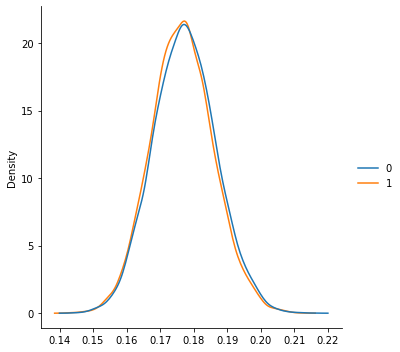

In [94]:
sns.displot([cv_1,cv_2],kind='kde')

## High p-value
Let us see for very high p-value.

In [95]:
p_values_exc[0]

0.9783131888482115

In [96]:
cord[0]

'1,0'

In [97]:
cv_1 = cv_list_exc[1]
cv_2 = cv_list_exc[0]

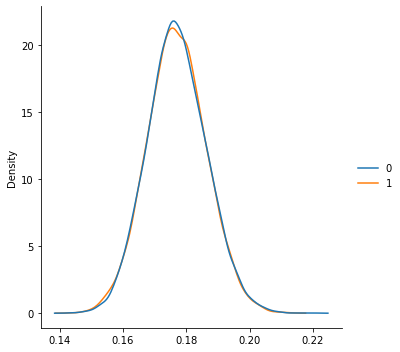

In [98]:
sns.displot([cv_1,cv_2],kind='kde')

## Middle p-value
And now for a middle p-value.

In [99]:
p_values_exc[23]

0.1449137168873294

In [100]:
cord[23]

'7,2'

In [101]:
cv_1 = cv_list_exc[7]
cv_2 = cv_list_exc[2]

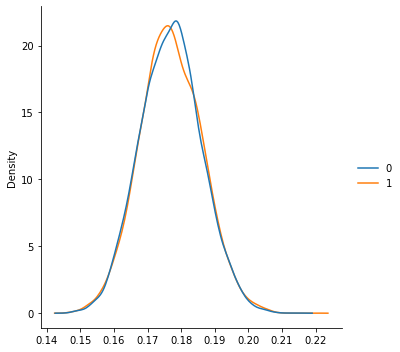

In [102]:
sns.displot([cv_1,cv_2],kind='kde')

There is more difference in the middle valued p-value. 

Let us examine for when the test passes.

In [103]:
for i in range(0,10):
    print(statistics_exc[i], p_values_exc[i])
    s = statistics_exc[i] < p_values_exc[i]
    print(s)
    print(cord[i])

0.0067 0.9783131888482115
True
1,0
0.0108 0.6042251174586427
True
2,0
0.0103 0.6637453476707832
True
2,1
0.0147 0.23009750585879926
True
3,0
0.0147 0.23009750585879926
True
3,1
0.0189 0.05619041963691477
True
3,2
0.007 0.967081996278138
True
4,0
0.0078 0.9212790168134688
True
4,1
0.0094 0.7689615674766569
True
4,2
0.0125 0.41538042565668437
True
4,3


Test passes for all first 10 pairs. We actually already plotted one of these. The one with the high p-value. They looked similar.

Look at some of the failed tests.

In [104]:
for i in range(10,20):
    print(statistics_exc[i], p_values_exc[i])
    s = statistics_exc[i] < p_values_exc[i]
    print(s)
    print(cord[i])

0.0108 0.6042251174586427
True
5,0
0.0128 0.38574770611965037
True
5,1
0.0103 0.6637453476707832
True
5,2
0.0186 0.06288105634528753
True
5,3
0.0116 0.5116055794163079
True
5,4
0.0262 0.0020876942681196885
False
6,0
0.0223 0.013843815295457773
False
6,1
0.0229 0.010555068162685212
False
6,2
0.0325 5.166734198543513e-05
False
6,3
0.0253 0.003318920429564209
False
6,4


In [105]:
cord[15]

'6,0'

In [106]:
cv_1 = cv_list_exc[6]
cv_2 = cv_list_exc[0]

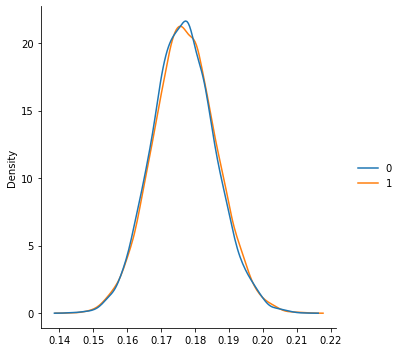

In [107]:
sns.displot([cv_1,cv_2],kind='kde')

Does not look any less similar than the passed test.

Plot several density plots of cv distributions that passed, and that failed and compare.

In [133]:
#passed
cv_1 = cv_list_exc[0]
cv_2 = cv_list_exc[1]
#passed
cv_3 = cv_list_exc[2]
cv_4 = cv_list_exc[0]
#not passed
cv_5 = cv_list_exc[6]
cv_6 = cv_list_exc[0]
# not passed
cv_7 = cv_list_exc[6]
cv_8 = cv_list_exc[1]

In [134]:
pass_1 = [cv_1, cv_2]
pass_2 = [cv_3, cv_4]
fail_1 = [cv_5, cv_6]
fail_2 = [cv_7, cv_8]

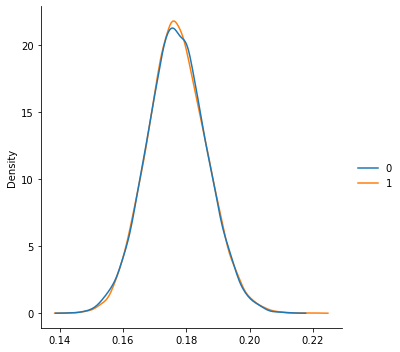

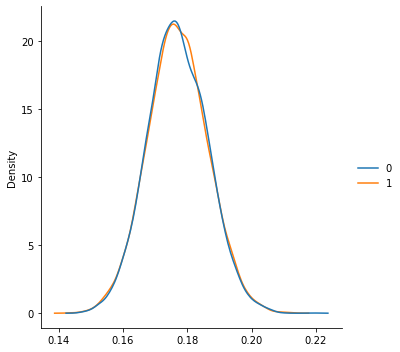

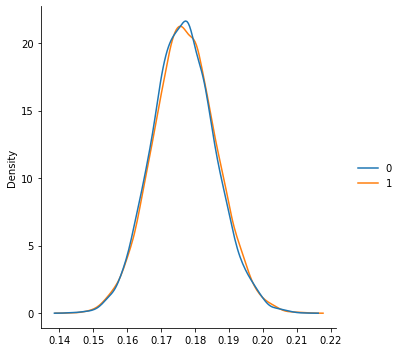

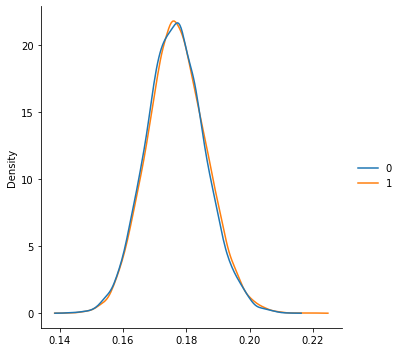

In [110]:
sns.displot(pass_1,kind='kde')
sns.displot(pass_2,kind='kde')
sns.displot(fail_1,kind='kde')
sns.displot(fail_2,kind='kde')

There is no more or less similarity between the distributions even though the first two plots show passed tests, and the last two shows failed tests.

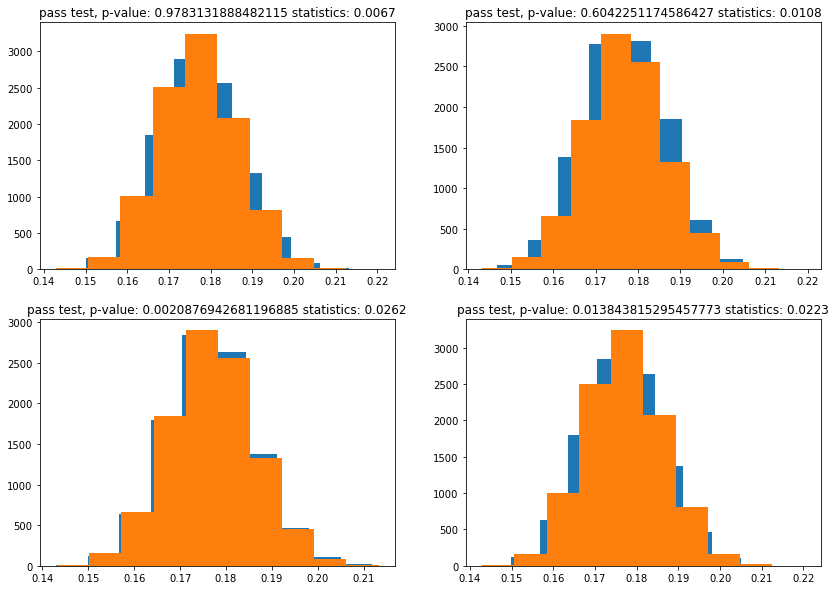

In [138]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].hist(cv_1)
axs[0, 0].hist(cv_2)
s1 = statistics_exc[0]
p1 = p_values_exc[0]
axs[0, 0].set_title('pass test, p-value: '+ str(p1) +' statistics: '+ str(s1))
axs[0, 1].hist(cv_3)
axs[0, 1].hist(cv_4)
s2 = statistics_exc[1]
p2 = p_values_exc[1]
axs[0, 1].set_title('pass test, p-value: '+ str(p2) +' statistics: '+str(s2))
axs[1, 0].hist(cv_5)
axs[1, 0].hist(cv_6)
s3 = statistics_exc[15]
p3 = p_values_exc[15]
axs[1, 0].set_title('fail test, p-value: '+str(p3)+ ' statistics: '+str(s3))
axs[1, 1].hist(cv_7)
axs[1, 1].hist(cv_8)
s4 = statistics_exc[16]
p4 = p_values_exc[16]
axs[1, 1].set_title('fail test, p-value: '+str(p4) +' statistics: '+str(s4))
plt.show()

Maybe KS-test is not a good test for comparing distributions.

Tried Mann-Whitney U-test, but all tests failed.